In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

%matplotlib inline

In [3]:
base_file_path = "../out/base_controller/20250208_092114/eval"
perfect_file_path = "../out/mpc_perfect/20250207_143021/eval"
linear_file_path = "../out/mpc_predictor_linear/20250722_203255/eval"
xgboost_file_path = "../out/mpc_predictor_xgboost/20250722_205950/eval"
recurrent_file_path = "../out/mpc_predictor_recurrent/20250722_204540/eval"
times_net_file_path = "../out/mpc_predictor_times_net/20250723_032007/eval"
time_mixer_file_path = "../out/mpc_predictor_time_mixer/20250723_030559/eval"
retrain_linear_file_path = "../out/mpc_retrain_predictor_linear/20250723_033326/eval"
retrain_recurrent_file_path = "../out/mpc_retrain_predictor_recurrent/20250723_034609/eval"
retrain_time_mixer_file_path = "../out/mpc_retrain_predictor_time_mixer/20250723_035851/eval"
retrain_times_net_file_path = "../out/mpc_retrain_predictor_times_net/20250723_043739/eval"
retrain_xgboost_file_path = "../out/mpc_retrain_predictor_xgboost/20250725_124430/eval"

init_ts = 1514848500

In [4]:
def plot_ctr_logic(eval_dir: str, run=0, env=0, window_days=7, name="", save_path=None):
    # --------------------------------------------------
    # CONFIG & FILES
    # --------------------------------------------------
    base = Path(eval_dir)
    perf_mpc = Path(perfect_file_path) / "trajectories" / f"eval_run_{run}_of_env_{env}.csv"
    traj_csv  = base / "trajectories" / f"eval_run_{run}_of_env_{env}.csv"
    pred_load = base / "predictions"  / f"eval_run_{run}_of_env_{env}_load.csv"
    pred_pv   = base / "predictions"  / f"eval_run_{run}_of_env_{env}_pv.csv"
    pred_prc  = base / "predictions"  / f"eval_run_{run}_of_env_{env}_price.csv"

    TIME_COL = "time"          # name in prediction CSVs
    HEAT_UP  = 96              # history steps

    name = f"{name} " if name else ""

    # --------------------------------------------------
    # HELPERS
    # --------------------------------------------------
    def _load_pred(path):
        df = pd.read_csv(path).iloc[HEAT_UP:].reset_index(drop=True)
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], unit="s")

        pred_cols = sorted([c for c in df if c.startswith("pred_")],
                           key=lambda x: int(x.split("_")[1]))
        H = len(pred_cols)
        first_c, last_c = pred_cols[0], pred_cols[-1]

        out = df[[TIME_COL, "true", first_c, last_c]].rename(
            columns={"true": "y_true",
                     first_c: "y_pred_first",
                     last_c: "y_pred_last"})
        return out, H

    def _align(df, H):
        """Shift true and first-ahead so they line up with last-ahead (horizon-H)."""
        df["y_true"]       = df["y_true"].shift(-H)
        df["y_pred_first"] = df["y_pred_first"].shift(-(H-1))
        # y_pred_last needs no shift
        return df.iloc[:-H]        # drop NaNs at end

    # --------------------------------------------------
    # LOAD & ALIGN
    # --------------------------------------------------
    load_raw,  H = _load_pred(pred_load)
    pv_raw,    _ = _load_pred(pred_pv)
    prc_raw,   _ = _load_pred(pred_prc)

    load_al  = _align(load_raw, H).add_prefix("load_");  load_al.rename(columns={"load_time":TIME_COL},  inplace=True)
    pv_al    = _align(pv_raw,   H).add_prefix("pv_");    pv_al.rename(  columns={"pv_time":TIME_COL},    inplace=True)
    prc_al   = _align(prc_raw,  H).add_prefix("price_"); prc_al.rename( columns={"price_time":TIME_COL}, inplace=True)

    # master clock
    t        = prc_al[TIME_COL]
    traj_df  = pd.read_csv(traj_csv).iloc[H:].reset_index(drop=True); traj_df  = traj_df.iloc[:len(t)].copy(); traj_df[TIME_COL] = t.values        # stamp trajectory with same clock
    ptraj_df = pd.read_csv(perf_mpc).iloc[H:].reset_index(drop=True); ptraj_df  = ptraj_df.iloc[:len(t)].copy(); ptraj_df[TIME_COL] = t.values     # stamp trajectory with same clock
    traj_df["perf_soc"] = ptraj_df["soc"]  # add perfect MPC SoC

    df = (traj_df
          .merge(load_al,  on=TIME_COL)
          .merge(pv_al,    on=TIME_COL)
          .merge(prc_al,   on=TIME_COL))

    # keep just the first N days
    df = df.iloc[: window_days*96]

    # --------------------------------------------------
    # PLOT
    # --------------------------------------------------
    plt.rcParams.update({"font.size": 9})
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 8),
                            gridspec_kw={"hspace": 0.15, "top": 0.92, "bottom": -0.15})

    # PRICE
    axs[0].plot(df[TIME_COL], df["price_y_true"],        color="black", lw=1, label="True")
    axs[0].plot(df[TIME_COL], df["price_y_pred_first"],  lw=1.1, ls="--", label="First Pred. (shifted by -1) ")
    axs[0].plot(df[TIME_COL], df["price_y_pred_last"],   lw=1.1, ls=":",  label=f"Last Pred. (shifted by -{H})")
    axs[0].set_ylabel("cent / kWh")
    axs[0].set_title(f"{name}Price")
    axs[0].legend(frameon=True, loc="upper right", framealpha=0.8);  axs[0].grid(True, ls="--", alpha=0.3)

    # LOAD
    axs[1].plot(df[TIME_COL], df["load_y_true"],       color="black", lw=1)
    axs[1].plot(df[TIME_COL], df["load_y_pred_first"], lw=1.1, ls="--")
    axs[1].plot(df[TIME_COL], df["load_y_pred_last"],  lw=1.1, ls=":")
    axs[1].set_ylabel("kWh / 15 min"); axs[1].set_title(f"{name}Load")
    axs[1].grid(True, ls="--", alpha=0.3)

    # PV
    axs[2].plot(df[TIME_COL], df["pv_y_true"],       color="black", lw=1)
    axs[2].plot(df[TIME_COL], df["pv_y_pred_first"], lw=1.1, ls="--")
    axs[2].plot(df[TIME_COL], df["pv_y_pred_last"],  lw=1.1, ls=":")
    axs[2].set_ylabel("kWh / 15 min"); axs[2].set_title(f"{name}PV Generation")
    axs[2].grid(True, ls="--", alpha=0.3)

    # CONTROL
    ax_soc = axs[3]
    ax_soc.fill_between(df[TIME_COL], df["soc"], step="pre", alpha=0.35, label="SoC")
    ax_soc.set_ylim(0, 1); ax_soc.set_ylabel("SoC (p.u.)")
    ax_soc.plot(df[TIME_COL], df["perf_soc"], color="black", lw=1, ls="--", label="Perfect MPC SoC")
    ax_p   = ax_soc.twinx()
    ax_p.plot(df[TIME_COL], df["e_bat"], alpha=0.6, label="Battery Energy")
    ax_p.set_ylabel("kWh / 15 min")
    l1,l2 = ax_soc.get_legend_handles_labels(); l3,l4 = ax_p.get_legend_handles_labels()
    ax_soc.legend(l1+l3, l2+l4, loc="upper right", frameon=True, framealpha=0.8)
    ax_soc.set_title(f"{name}Control (SoC & Battery Energy)")
    ax_soc.grid(True, ls="--", alpha=0.3)

    # X-axis dd.mm.
    axs[-1].xaxis.set_major_locator(mdates.DayLocator())
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
    axs[-1].set_xlabel("Date")

    fig.align_ylabels(); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


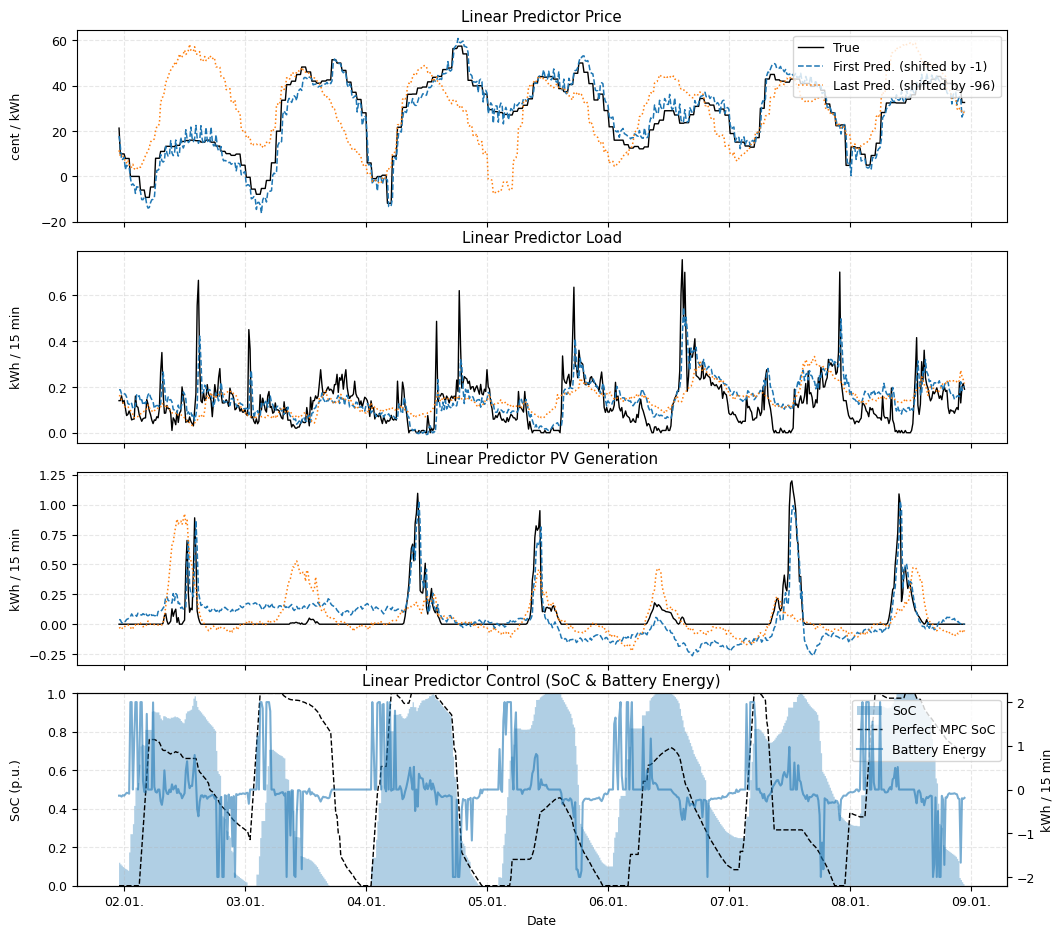

In [6]:
plot_ctr_logic(linear_file_path, name="Linear Predictor", save_path="../out/ctr_plot_linear.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


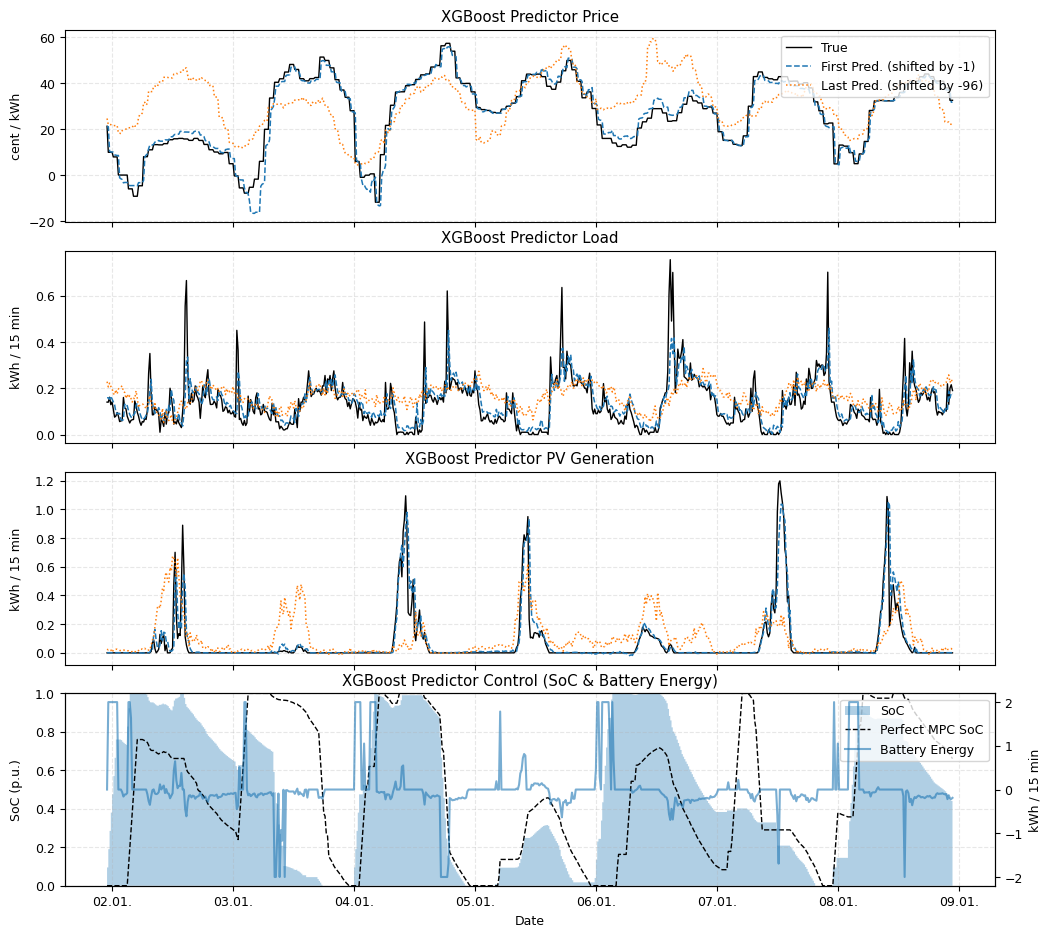

In [7]:
plot_ctr_logic(xgboost_file_path, name="XGBoost Predictor", save_path="../out/ctr_plot_xgboost.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


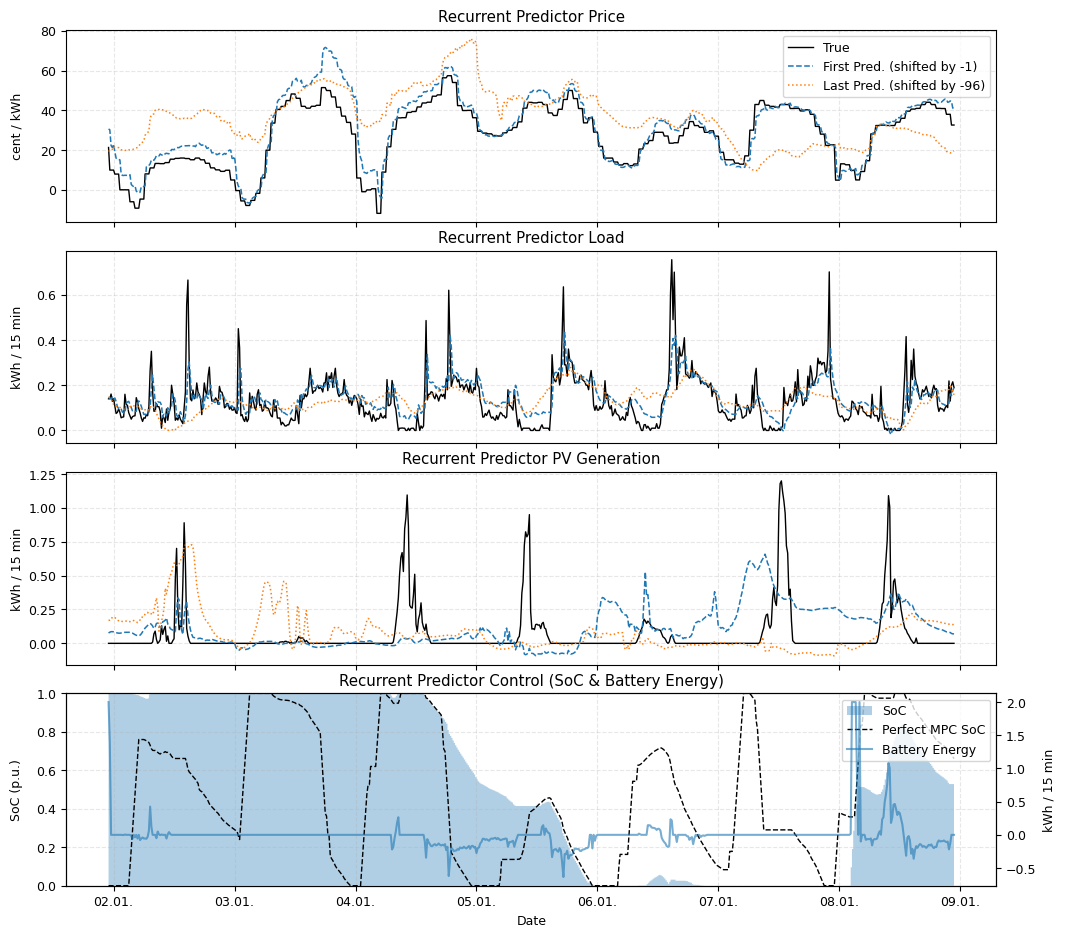

In [8]:
plot_ctr_logic(recurrent_file_path, name="Recurrent Predictor", save_path="../out/ctr_plot_recurrent.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


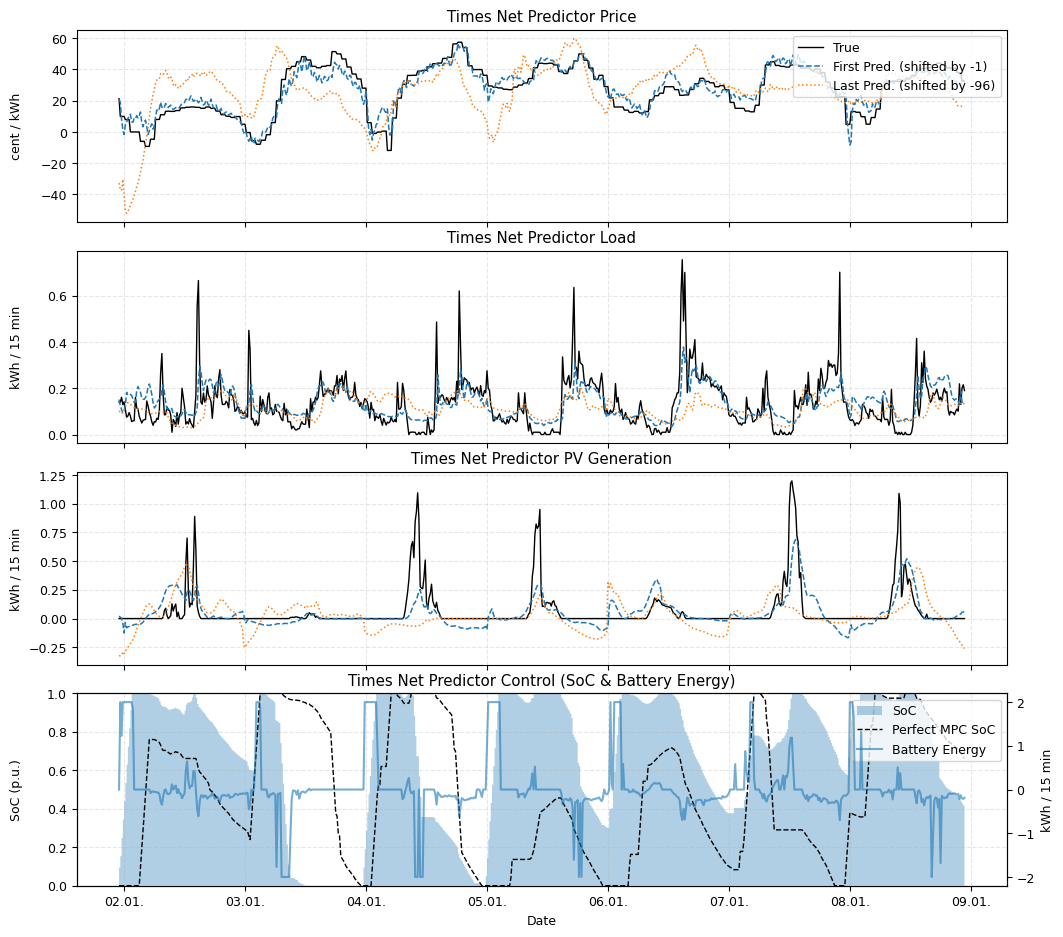

In [9]:
plot_ctr_logic(times_net_file_path, name="Times Net Predictor", save_path="../out/ctr_plot_times_net.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


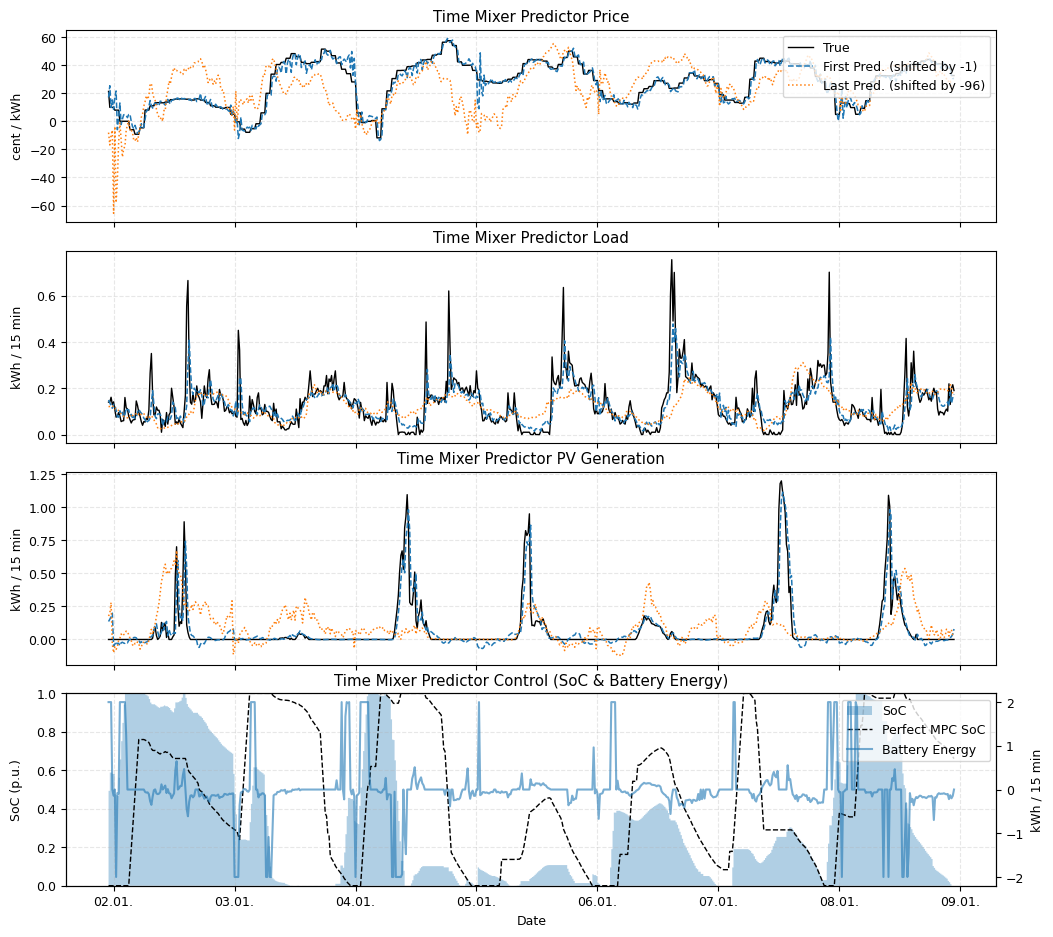

In [10]:
plot_ctr_logic(time_mixer_file_path, name="Time Mixer Predictor", save_path="../out/ctr_plot_time_mixer.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


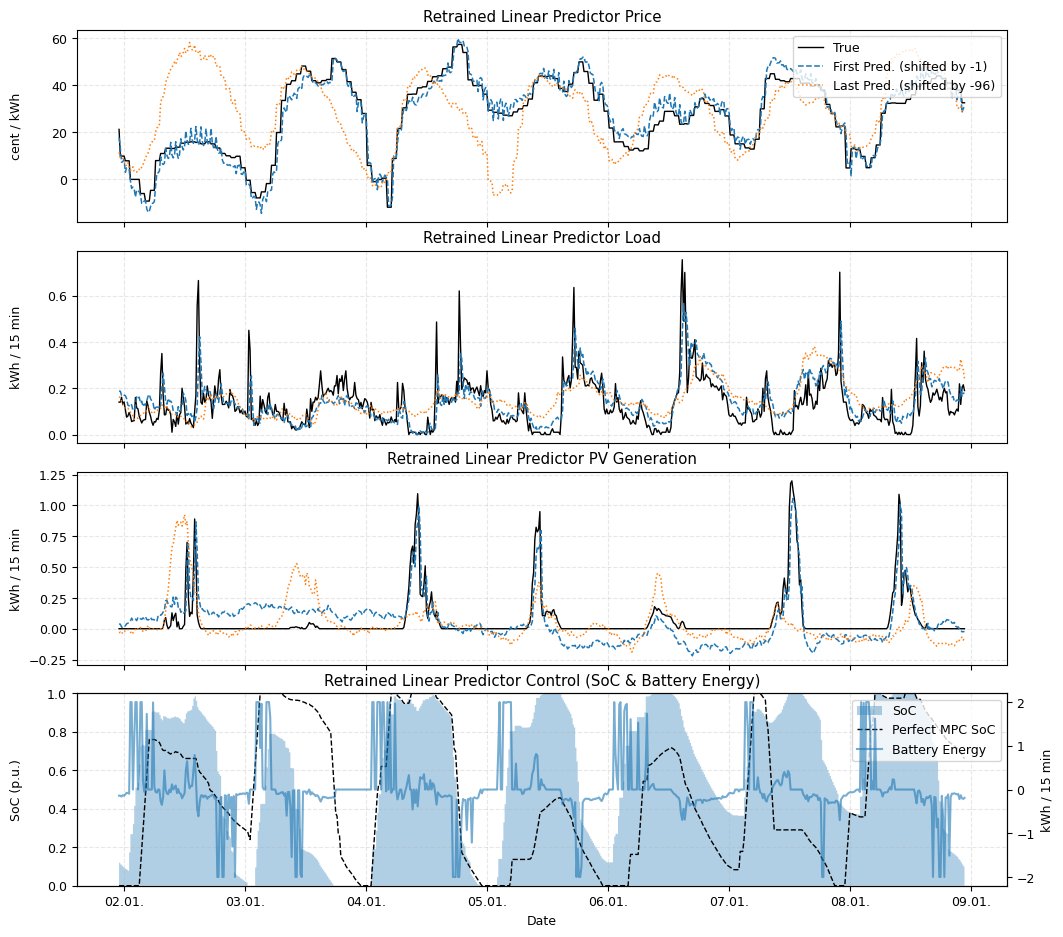

In [11]:
plot_ctr_logic(retrain_linear_file_path, name="Retrained Linear Predictor", save_path="../out/ctr_plot_retrain_linear.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


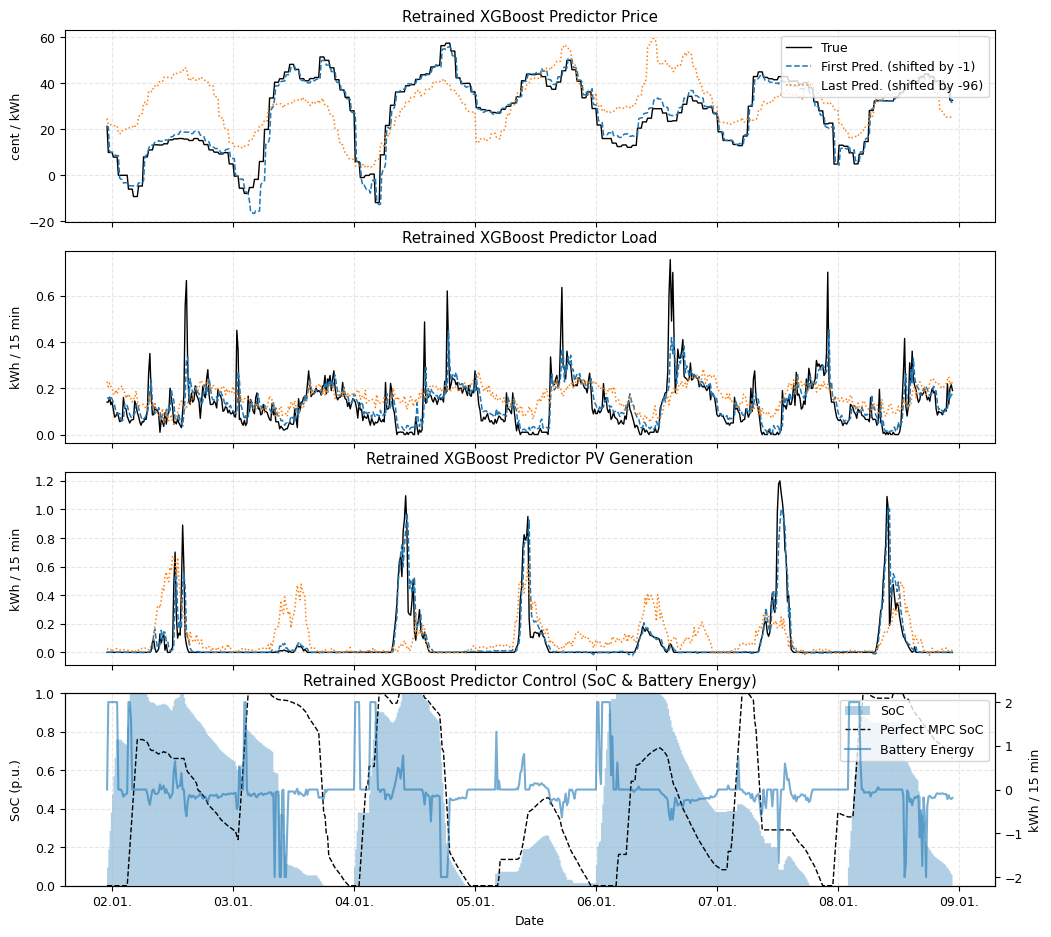

In [12]:
plot_ctr_logic(retrain_xgboost_file_path, name="Retrained XGBoost Predictor", save_path="../out/ctr_plot_retrain_xgboost.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


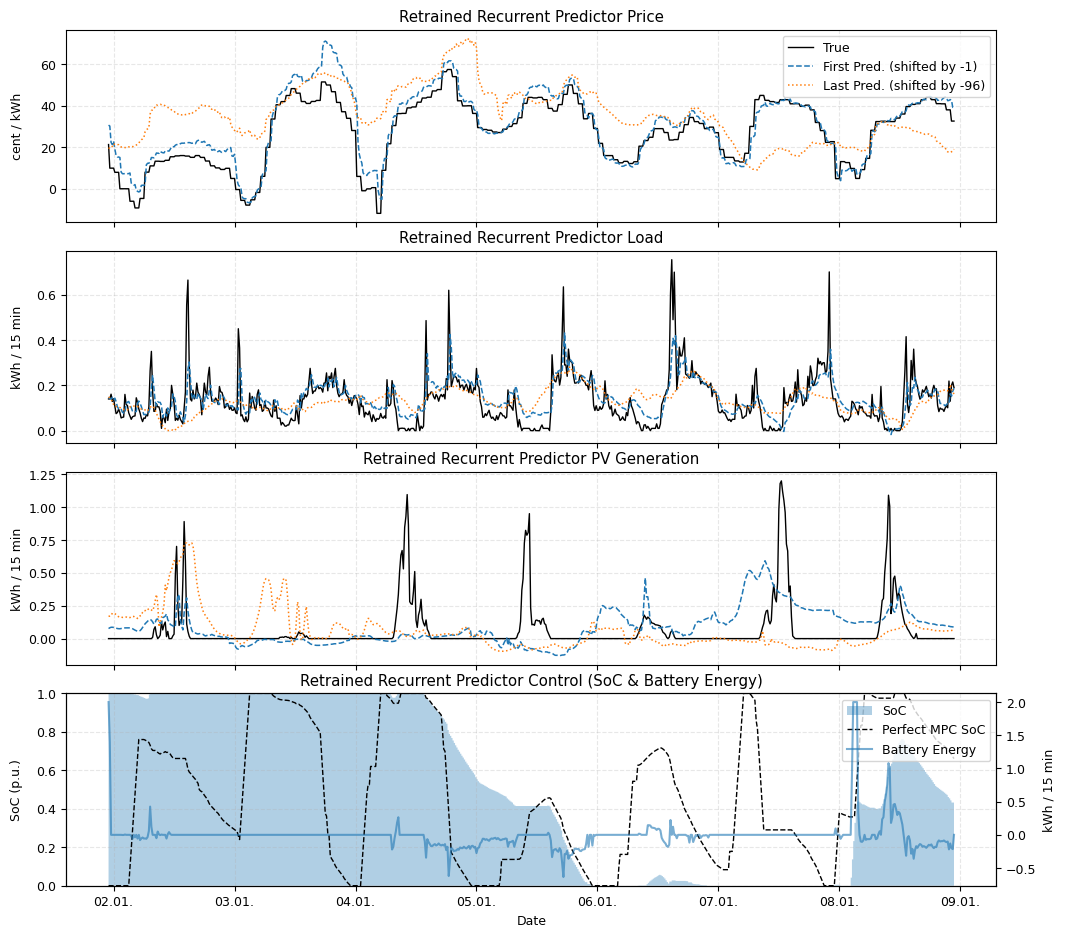

In [13]:
plot_ctr_logic(retrain_recurrent_file_path, name="Retrained Recurrent Predictor", save_path="../out/ctr_plot_retrain_recurrent.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


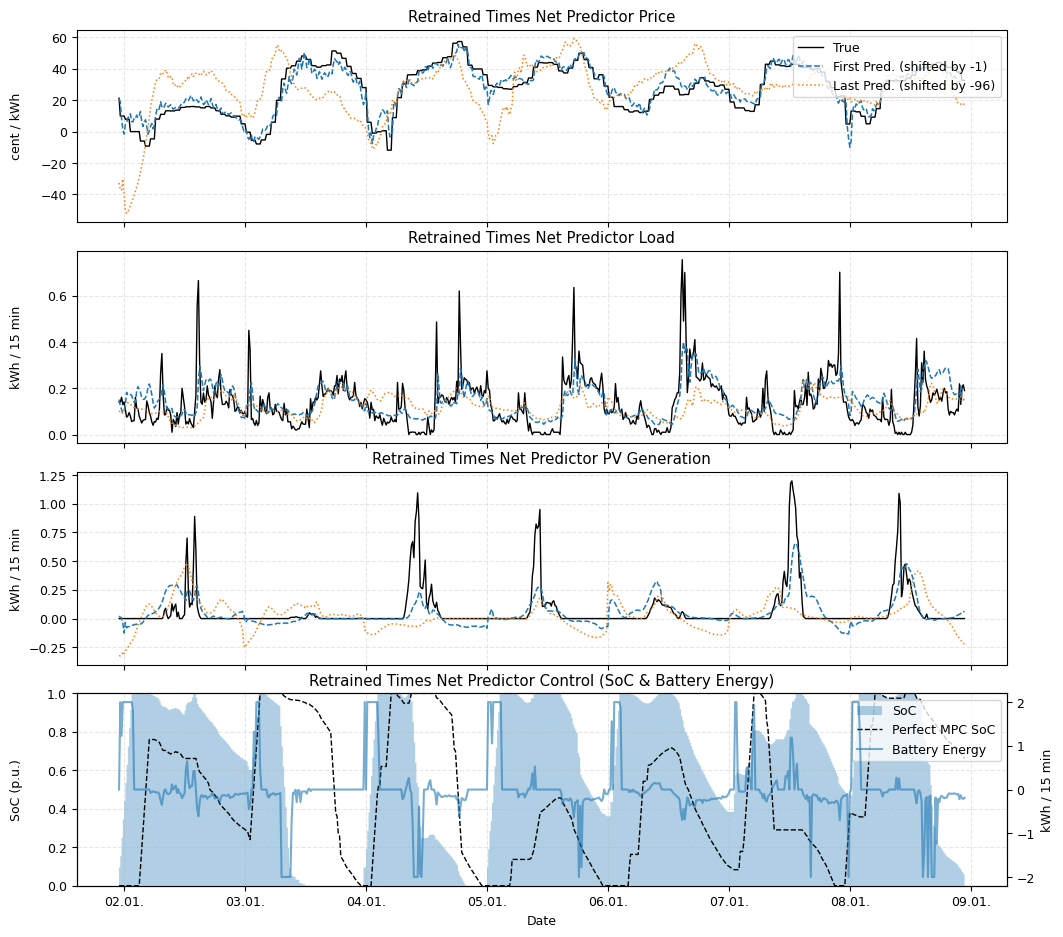

In [14]:
plot_ctr_logic(retrain_times_net_file_path, name="Retrained Times Net Predictor", save_path="../out/ctr_plot_retrain_times_net.png")

/tmp/ipykernel_7111/4257251266.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.align_ylabels(); plt.tight_layout()


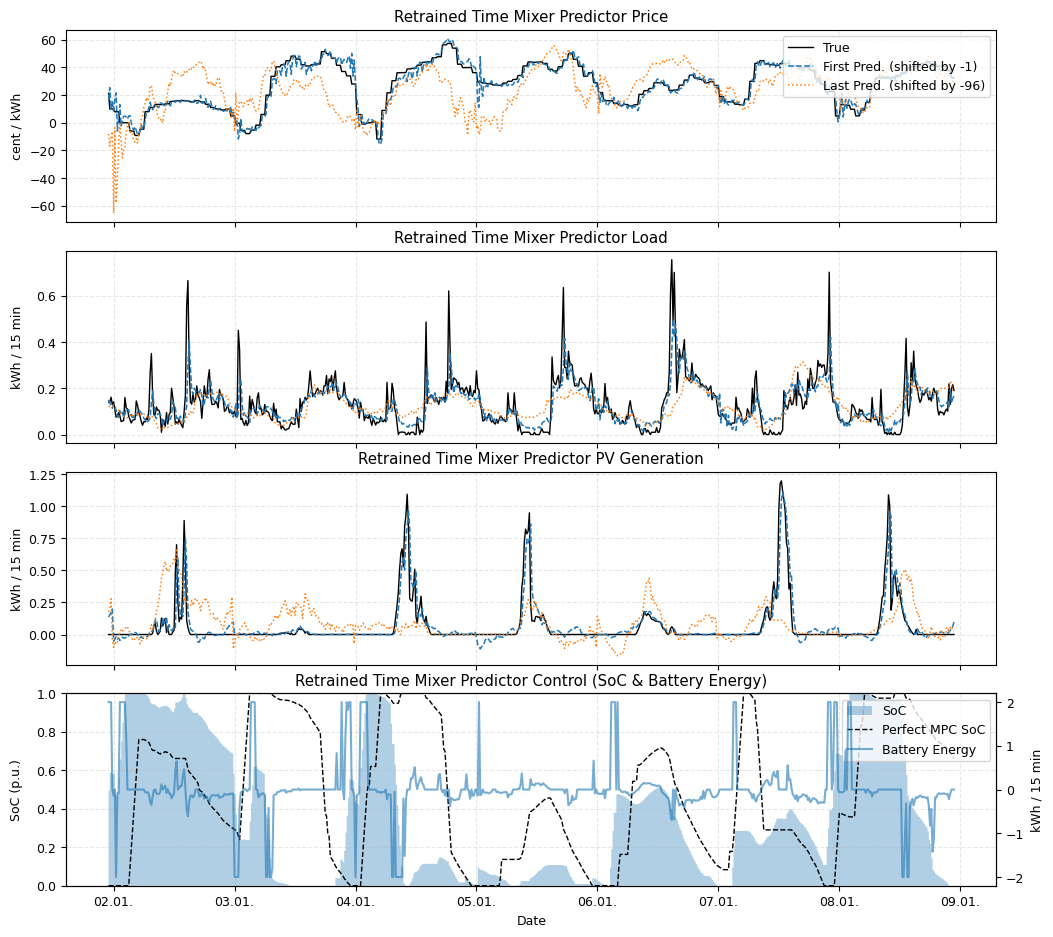

In [15]:
plot_ctr_logic(retrain_time_mixer_file_path, name="Retrained Time Mixer Predictor", save_path="../out/ctr_plot_retrain_time_mixer.png")

In [16]:
BASE_CTR = 99.78
rgain = lambda x, y: round(((x*100)/y)-100, 2)

# Create a function to read evaluation metrics from each file
def get_evaluation_metrics(file_paths):
    results = []
    
    for name, path in file_paths.items():
        if not path:  # Skip empty paths
            print(f"Skipping '{name}' due to empty path.")
            continue
            
        try:
            # Get the base directory path by removing any trailing parts
            eval_path = f"{path}/evaluation_results.csv"
            df = pd.read_csv(eval_path)
            
            # Get resulting SoC from the last row of the trajectories file
            traj_path = f"{path}/trajectories/eval_run_0_of_env_0.csv"
            try:
                traj_df = pd.read_csv(traj_path)
                resulting_soc = round(traj_df['soc'].iloc[-1], 2)
            except Exception as e:
                print(f"Error reading SoC for {name}: {e}")
                resulting_soc = None

            # Extract metrics
            result = {
                'model': name,
                'Electricity Revenue (EUR)': round(df['return'].iloc[0] / 100, 2),
                'Electricity Generation (kWh)': round(-1 * df['total_consumption'].iloc[0], 2),
                'Resulting SoC (%)': resulting_soc,
                'Revenue Gain (%)': rgain(df['return'].iloc[0] / 100, BASE_CTR),
                'total_price': df['total_price'].iloc[0],
                'first_ts': df['first_ts'].iloc[0],
                'env_steps': df['env_steps'].iloc[0],
            }
            results.append(result)
        except Exception as e:
            print(f"Error processing {name}: {e}")
    
    return pd.DataFrame(results)

# Create a dictionary of model names and their file paths using original paths
models = {
    'base': base_file_path,
    'perfect': perfect_file_path,
    'linear': linear_file_path,
    'xgboost': xgboost_file_path,
    'recurrent': recurrent_file_path,
    'time_mixer': time_mixer_file_path,
    'times_net': times_net_file_path,
    'retrain_linear': retrain_linear_file_path,
    'retrain_xgboost': retrain_xgboost_file_path,
    'retrain_recurrent': retrain_recurrent_file_path,
    'retrain_time_mixer': retrain_time_mixer_file_path,
    'retrain_times_net': retrain_times_net_file_path,
}

#  Get evaluation metrics and display the results
results_df = get_evaluation_metrics(models)
display(results_df)

,model,Electricity Revenue (EUR),Electricity Generation (kWh),Resulting SoC (%),Revenue Gain (%),total_price,first_ts,env_steps
0,base,99.78,651.35,0.50,0.00,328820.960401,1514848500,9212
1,perfect,334.68,500.78,0.16,235.42,328820.960401,1514848500,9212
2,linear,172.24,494.68,0.11,72.62,328820.960401,1514848500,9212
3,xgboost,203.71,555.80,0.03,104.16,328820.960401,1514848500,9212
4,recurrent,108.80,591.23,0.10,9.04,328820.960401,1514848500,9212
5,time_mixer,151.20,515.68,0.06,51.53,328820.960401,1514848500,9212
6,times_net,178.58,516.58,0.00,78.97,328820.960401,1514848500,9212
7,retrain_linear,204.18,523.38,0.15,104.63,328820.960401,1514848500,9212
8,retrain_xgboost,206.70,547.98,0.16,107.16,328820.960401,1514848500,9212
9,retrain_recurrent,166.61,561.93,0.00,66.98,328820.960401,1514848500,9212
